# Twitter vs Stocks Change Data Analysis

## Data Cleaning Notebook

In [38]:
# Packages:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from urllib.request import urlopen
import json
import datetime
import numpy as np
import warnings
from textblob import TextBlob
import re
from wordcloud import WordCloud

### Tweets DF, Sentimental Analysis and Tweets Cleaning Functions

In [39]:
# Function to clean Tweet Texts:
def cleantext(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) # Remove Mentions
    text = re.sub(r"#", "", text) # Remove Hashtags Symbol
    text = re.sub(r"RT[\s]+", "", text) # Remove Retweets
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove The Hyper Link
    
    return text

In [40]:
def Tweet_Clean(csv):

    # Pulling CSV with Twitter information. Check ceo_name.ipynb for data extraction:
    ceo_tweets = pd.read_csv(csv)
    columns_chosed = ['created_at','full_text','id','source','favorite_count','retweet_count']
    ceo_tweets = ceo_tweets[columns_chosed]

    # Filtering Dataframe for tweets since 2019:
    ceo_tweets["created_at"] = pd.to_datetime(ceo_tweets["created_at"]).dt.date
    ceo_tweets["created_at"] = pd.to_datetime(ceo_tweets["created_at"])
    ceo_tweets = ceo_tweets[ceo_tweets["created_at"]>='2019-01-01']

    # Clean The Text:
    ceo_tweets['full_text'] = ceo_tweets['full_text'].apply(cleantext)

    # Checking weekends:
    ceo_tweets["Day of Week"] = ceo_tweets['created_at'].dt.dayofweek
    ceo_tweets['orig_date'] = ceo_tweets['created_at']

    # Moving Tweets made during weekend to Monday:
    for i in range(ceo_tweets.shape[0]):
        if ceo_tweets['Day of Week'].loc[i] == 5:
            ceo_tweets['created_at'].loc[i] = ceo_tweets['created_at'].loc[i]+ datetime.timedelta(days=2)
        if ceo_tweets['Day of Week'].loc[i] == 6:
            ceo_tweets['created_at'].loc[i] = ceo_tweets['created_at'].loc[i]+ datetime.timedelta(days=1)

    # Get The Subjectivity
    def sentiment_analysis(ds):
        sentiment = TextBlob(ds['full_text']).sentiment
        return pd.Series([sentiment.subjectivity, sentiment.polarity])

    # Adding Subjectivity & Polarity
    ceo_tweets[["subjectivity", "polarity"]] = ceo_tweets.apply(sentiment_analysis, axis=1)

    # Aggregating Tweets by Date:
    ceo_tweets = (    
        ceo_tweets.groupby(["created_at"])
        .agg(
            Tweets=("full_text", "sum"),
            Agg_count=("full_text", "count"),
            Agg_retweet=("retweet_count", "sum"),
            Agg_favorite=("favorite_count", "sum"),
            Subjectivity_mean=("subjectivity", "mean"),
            Polarity_mean=("polarity", "mean"),
        )
        .reset_index()
    )
    ceo_tweets = ceo_tweets.rename(columns={"created_at":'Date'})

    #Scaling Polarity from -1 to 1 scale to 0 to 1 scale:
    
    old_max = ceo_tweets["Polarity_mean"].max(axis=0)
    old_min = ceo_tweets["Polarity_mean"].min(axis=0)  
    OldRange = old_max - old_min  
    new_min = 0
    new_max = 1
    NewRange = (new_max - new_min)  
    ceo_tweets["Polarity_scaled"] = (((ceo_tweets["Polarity_mean"] - old_min) * NewRange) / OldRange) + new_min
    
    ceo_tweets["Polarity_delta"] = ceo_tweets["Polarity_scaled"]-ceo_tweets["Polarity_scaled"].shift()

    return ceo_tweets

### Stock Data Cleaning Function

In [48]:
def Stock_Clean(stock):

    # Getting Data Stock prices. Source: Yahoo Finance.
    stock_df = pd.read_csv(stock, encoding = "ISO-8859-1", error_bad_lines=False)

    # Scaling Stock Change to 0 to 1:
    old_max = stock_df["Close"].max(axis=0)
    old_min = stock_df["Close"].min(axis=0)  
    OldRange = old_max - old_min  
    new_min = 0
    new_max = 1
    NewRange = (new_max - new_min)  
    stock_df["Close_scaled"] = (((stock_df["Close"] - old_min) * NewRange) / OldRange) + new_min
    
    stock_df["Close_delta"] = stock_df["Close_scaled"]-stock_df["Close_scaled"].shift()
    
    # stock_df['Return'] = stock_df['Close']
    # stock_df['Return']= np.log(stock_df['Close']/stock_df['Close'].shift())
    stock_df = stock_df.rename(columns={"Close":'Price','Close_Delta':'Price_Delta'})
    stock_df["Date"] = pd.to_datetime(stock_df["Date"]).dt.date
    stock_df["Date"] = pd.to_datetime(stock_df["Date"])
    
    return stock_df

### Function to Merge Stocks and Tweets DFs:

In [42]:
def Merging_dfs(stock_df,ceo_tweets):

    df_stock_tweets = stock_df.merge(ceo_tweets, how='left', on='Date')

    colnan = ['Agg_count','Agg_retweet','Agg_favorite','Subjectivity_mean','Polarity_mean','Polarity_scaled','Polarity_delta']
    
    for col in colnan:
        df_stock_tweets[col] = df_stock_tweets[col].fillna(0)

    df_stock_tweets['Tweets'] = df_stock_tweets['Tweets'].fillna('')
    
    return df_stock_tweets

## Word Cloud Function

In [55]:
def Word_Cloud(df_stock_tweets,ceo_name):
    allwords = " ".join([twts for twts in df_stock_tweets['Tweets']])
    wordCloud = WordCloud(width = 1000, height = 1000, random_state = 21, max_font_size = 119).generate(allwords)
    plt.figure(figsize=(20, 20), dpi=80)
    plt.imshow(wordCloud, interpolation = "bilinear")
    plt.axis("off")
    plt.savefig('../images/'+ceo_name+'.png', format='png', transparent=False, bbox_inches=None, 
            pad_inches=0.1, metadata=None);

## Applying the functions:

In [49]:
ceo_name = 'trader'
stock_code = 'Wheat2'

ceo_tweets = Tweet_Clean("../data/raw/"+ceo_name+".csv")
stock_df = Stock_Clean("../data/raw/"+stock_code+".csv")

<ipython-input-49-6b40b7d4646e>:4: DtypeWarning: Columns (160) have mixed types.Specify dtype option on import or set low_memory=False.
  ceo_tweets = Tweet_Clean("../data/raw/"+ceo_name+".csv")
C:\Users\Amalia\anaconda3\envs\dstoolkit\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-49-6b40b7d4646e>:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  stock_df = Stock_Clean("../data/raw/"+stock_code+".csv")


In [50]:
df_stock_tweets = Merging_dfs(stock_df,ceo_tweets)
df_stock_tweets

,Date,Price,Close_scaled,Close_delta,Tweets,Agg_count,Agg_retweet,Agg_favorite,Subjectivity_mean,Polarity_mean,Polarity_scaled,Polarity_delta
0,2021-12-02,295.75,0.914050,NaN,Great quote. stolen &amp; disseminatedTalk i...,20.0,28.0,64.0,0.339627,0.241893,0.379331,0.247805
1,2021-12-01,287.25,0.857851,-0.056198,Black Sea Futures:\n\n🌾Black Sea Wheat- 75.5kt...,13.0,30.0,31.0,0.164359,-0.000897,0.131526,-0.014569
2,2021-11-30,285.50,0.846281,-0.011570,_Cycles You can never have too much socks… 🧦 ...,20.0,16.0,74.0,0.241554,0.013376,0.146095,-0.049080
3,2021-11-29,297.50,0.925620,0.079339,Not yet. It’ll be higher in January: GASC- Bi...,28.0,2136.0,124.0,0.287041,0.061463,0.195174,-0.113520
4,2021-11-26,302.75,0.960331,0.034711,💥 🇪🇬 🌾 GASC has announced a wheat 🌾 tender for...,9.0,3.0,26.0,0.399537,0.172685,0.308694,0.204819
...,...,...,...,...,...,...,...,...,...,...,...,...
1300,2016-12-08,164.50,0.046281,-0.006612,,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1301,2016-12-07,163.50,0.039669,-0.006612,,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1302,2016-12-06,163.00,0.036364,-0.003306,,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1303,2016-12-05,162.25,0.031405,-0.004959,,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


,Date,Price,Close_scaled,Close_delta,Tweets,Agg_count,Agg_retweet,Agg_favorite,Subjectivity_mean,Polarity_mean,Polarity_scaled,Polarity_delta
0,2021-12-02,295.75,0.914050,NaN,Great quote. stolen &amp; disseminatedTalk i...,20.0,28.0,64.0,0.339627,0.241893,0.379331,0.247805
1,2021-12-01,287.25,0.857851,-0.056198,Black Sea Futures:\n\n🌾Black Sea Wheat- 75.5kt...,13.0,30.0,31.0,0.164359,-0.000897,0.131526,-0.014569
2,2021-11-30,285.50,0.846281,-0.011570,_Cycles You can never have too much socks… 🧦 ...,20.0,16.0,74.0,0.241554,0.013376,0.146095,-0.049080
3,2021-11-29,297.50,0.925620,0.079339,Not yet. It’ll be higher in January: GASC- Bi...,28.0,2136.0,124.0,0.287041,0.061463,0.195174,-0.113520
4,2021-11-26,302.75,0.960331,0.034711,💥 🇪🇬 🌾 GASC has announced a wheat 🌾 tender for...,9.0,3.0,26.0,0.399537,0.172685,0.308694,0.204819
...,...,...,...,...,...,...,...,...,...,...,...,...
1300,2016-12-08,164.50,0.046281,-0.006612,,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1301,2016-12-07,163.50,0.039669,-0.006612,,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1302,2016-12-06,163.00,0.036364,-0.003306,,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1303,2016-12-05,162.25,0.031405,-0.004959,,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


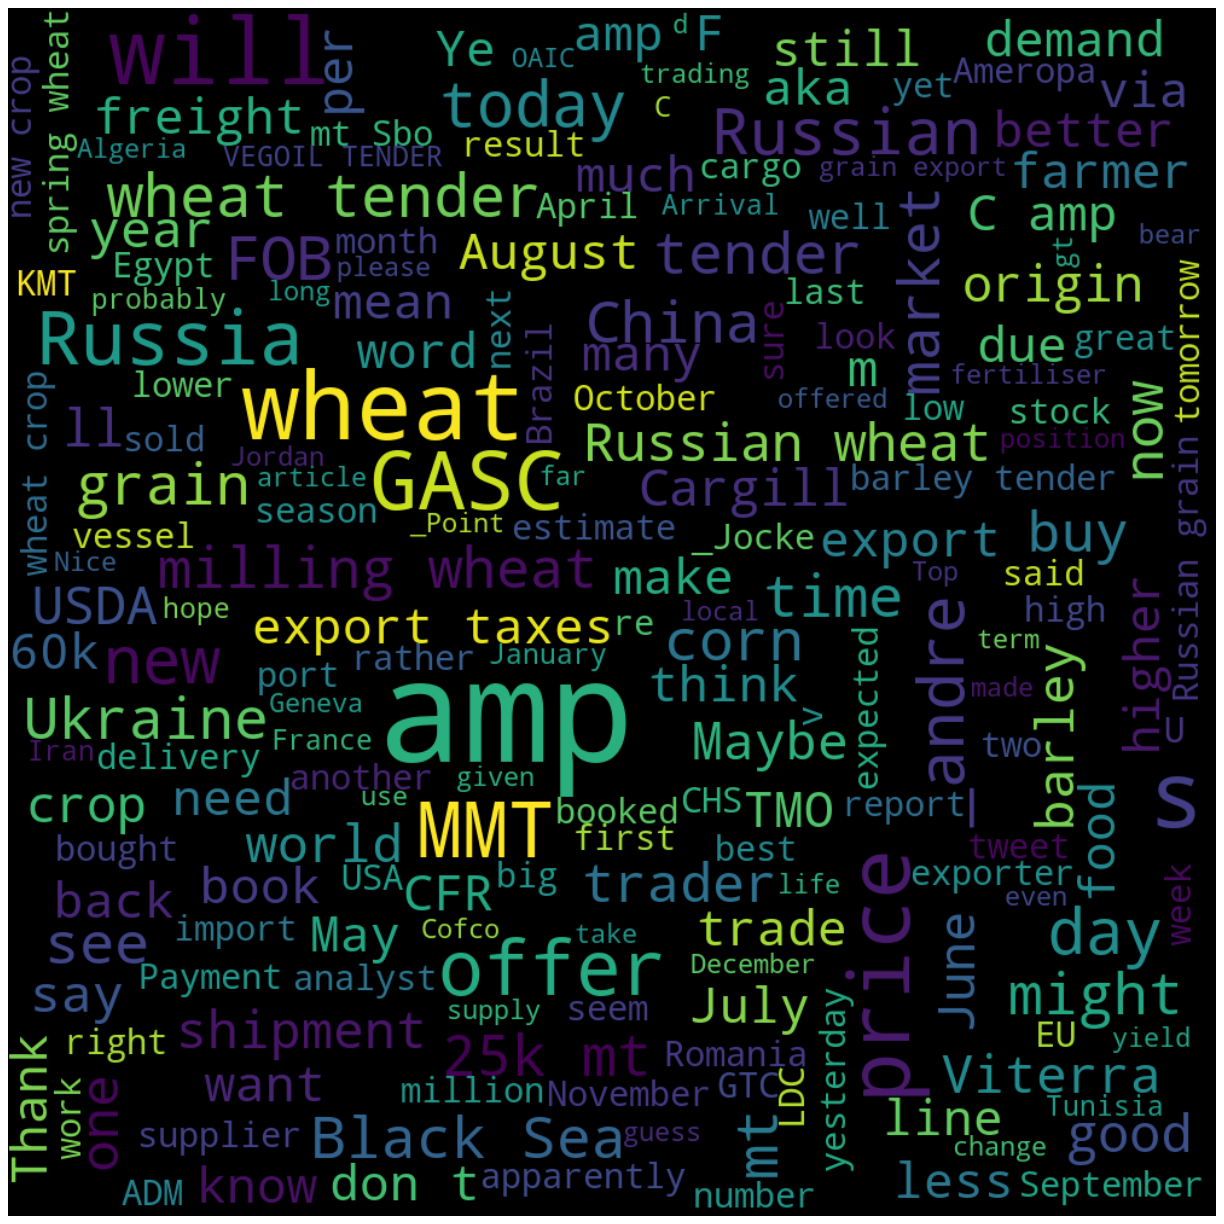

In [56]:
df_stock_tweets.to_csv('../data/processed/'+ceo_name+'_cleaned.csv', index=False)
Word_Cloud(df_stock_tweets,ceo_name);
df_stock_tweets

## Preliminary Plots

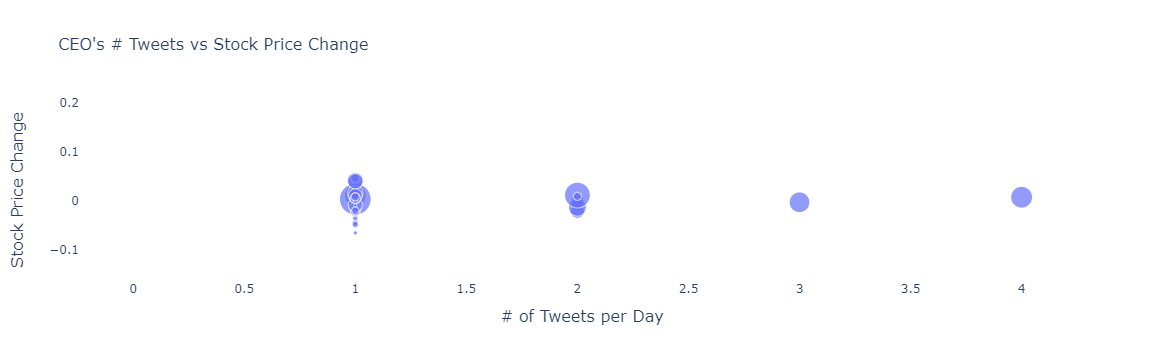

In [435]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets['Agg_count'],
    y= df_stock_tweets['Return'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_favorite'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_favorite']/1000)},
    hovertemplate= "Number of Tweets per Day: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Likes: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    yaxis={"title": {"text": "Stock Price Change", "font": {"size": 16}}},
    xaxis={"title": {"text": "# of Tweets per Day", "font": {"size": 16}}},
    # hovermode="x",
    title={'text': "CEO's # Tweets vs Stock Price Change", "font": {"size": 16}}
)
fig.show()

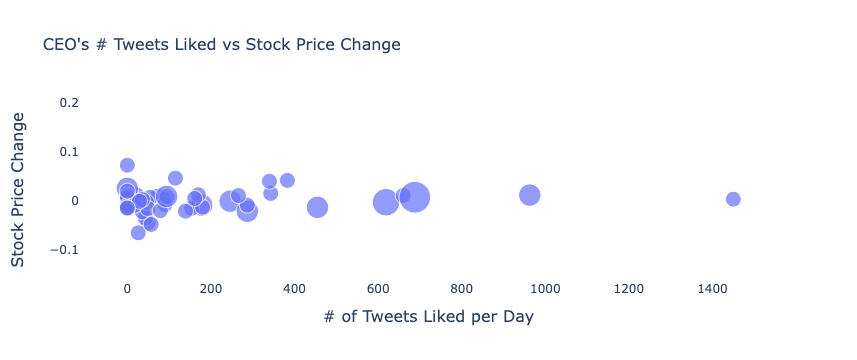

In [436]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets['Agg_favorite'],
    y= df_stock_tweets['Return'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_count'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_count']/1000)},
    hovertemplate= "Number of Tweets Liked per Day: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Tweets: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    yaxis={"title": {"text": "Stock Price Change", "font": {"size": 16}}},
    xaxis={"title": {"text": "# of Tweets Liked per Day", "font": {"size": 16}}},
    # hovermode="x",
    title={'text': "CEO's # Tweets Liked vs Stock Price Change", "font": {"size": 16}}
)
fig.show()

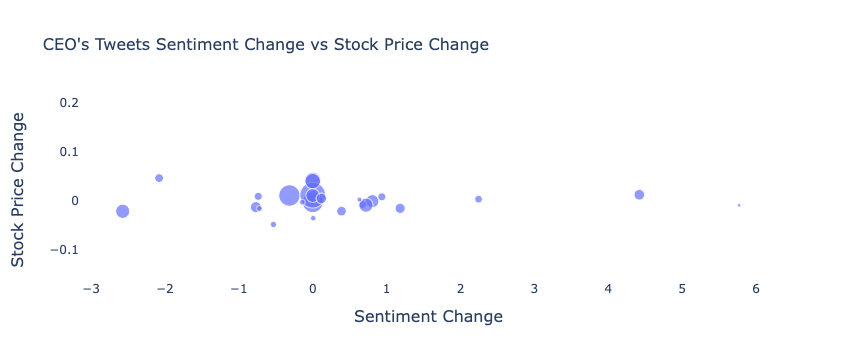

In [437]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets["Polarity_chg"],
    y= df_stock_tweets['Return'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_favorite'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_favorite']/1000)},
    hovertemplate= "Polarity of Tweets: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Likes: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    # hovermode="x",
    xaxis={"title": {"text": "Sentiment Change", "font": {"size": 16}}},
    yaxis={"title": {"text": "Stock Price Change", "font": {"size": 16}}},
    title={'text': "CEO's Tweets Sentiment Change vs Stock Price Change", "font": {"size": 16}}
)
fig.show()